# Vignette: Classification with Bayesian-Gaussian Frameworks and Its  Applications in Bioinformatics

## *Vignette Author:* Shirin Maki

## About Me

This is my first encounter with bioinformatics, I enrolled in this course driven by my passion for biology and curiosity about computer science. The advancement of biological research has always been deeply connected with technological progress, and programming offers me an ideal gateway to understand computer science. What fascinates me most is how just a few lines of code can transform complex, massive datasets, which is something that felt like "magic" before I began this course. From the start of the quarter to now, I've acquired numerous Python skills, including working with different variables, functions, and powerful libraries. While I'm still getting familiar with some concepts, I've already gained the ability to process simple data with code. I believe these skills will continue growing with me, enabling deeper exploration into biology and helping me pursue my scientific interests with greater confidence.

## Background

This vignette comes from techniques that I worked with in my project "Promoter Activity Prediction in DNA Sequences Based on Bayesian-Gaussian Framework and Its Broader Applications in Bioinformatics". Accurate prediction of promoter activity in DNA sequences is a fundamental challenge in genomics, as promoters serve as critical regulatory elements that initiate gene transcription and influence cellular functions. Traditional approaches to promoter identification often rely on complex machine learning models or motif scanning algorithms, which can be computationally intensive and lack interpretability for biological researchers. 

In contrast, a Bayesian-Gaussian framework offers an elegant statistical solution by leveraging the well-established relationship between sequence features, such as GC content, CpG island density, or transcription factor binding site frequency, and promoter functionality. This approach capitalizes on the observation that active promoters frequently exhibit distinct distributional characteristics in these features compared to inactive genomic regions, with GC content typically higher in functional promoters. By modeling each class as a Gaussian distribution (i.e. a bell-curve shaped normal distribution) and applying Bayes' theorem, researchers can compute the posterior probability that a given sequence functions as a promoter, providing not only a classification but also a measure of confidence in the prediction.

In July 2025, I got hooked on studying how short and long alleles in the SLC6A4 gene region might influence depression risk, so I decided to make it my project. As I worked through the data, I quickly realized the promoter region was the real key to telling these alleles apart, like a genetic switch that determines how the gene behaves. I needed a way to take new DNA sequences and figure out whether they were likely short or long variants, but with most tools, you just get a yes/no answer without knowing how sure you should be. That's when I started playing around with Bayes' theorem and Gaussian models, they gave me not just predictions but actual confidence levels, which was exactly what I needed for my project. What surprised me most was how the same approach worked for other problems too, like predicting promoter activity or even tracking where microbial samples came from. 

## An Example of Bayesian-Gaussian Classification using Animal Size

In the rest of this vignette, I will show how to do it, using the dataset of sizes of three different species according to their sex. The code will draw the boxplot and then make a prediction for the given sample size, with a confidence on each kind of species. The theorem behind the code works well for more complex tasks, too.

## Methods

### Showing the files in the specific directory

The first step is to check whether the files are in the correct directory, and whether they have the correct format. The data used in this example can be found in a zip file [here](./animal_size_data.zip). To follow along with the code below, you'll need to unzip it and put it in a folder called `resources` in your current working directory. If everything is set up correctly, you should see 6 `.csv` files.

In [7]:
from os import listdir
listdir('./resources')

['gorilla_female.csv',
 'coyote_female.csv',
 'cape_hare_male.csv',
 'coyote_male.csv',
 'cape_hare_female.csv',
 'gorilla_male.csv']

### Read and Store the Data

The next step is to read the files and then store them in a structure that is convenient for visualization. This function reads species-specific length data from CSV files in a directory. Each file starts with a `#SpeciesName` header followed by numerical measurements. The code parses the species name from the header, converts all subsequent lines to floating-point values (ignoring empty lines), and organisters the data into a dictionary where keys are species names and values are lists of lengths.

In [8]:
import os

def read_species_data(directory):

    species_data = {}
    
    for filename in os.listdir(directory):
        if not filename.endswith('.csv'):
            continue
            
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            species_name = f.readline().strip().lstrip('#')
            
            lengths = [float(line.strip()) for line in f if line.strip()]
            
            species_data[species_name] = lengths
    
    return species_data

species_length = read_species_data('resources')
print(species_length)

{'gorilla_female': [144.98, 134.59, 137.18, 140.58, 148.95, 140.0, 139.81, 137.5, 147.6, 142.05], 'coyote_female': [87.86, 76.62, 84.35, 83.25, 86.48, 83.85, 84.35, 82.28, 89.67, 81.49], 'cape_hare_male': [52.01, 49.98, 52.25, 46.35, 53.39, 48.11, 52.47, 50.07, 51.92, 55.37], 'coyote_male': [91.95, 91.57, 89.35, 90.13, 84.66, 89.46, 92.2, 87.72, 94.19, 83.81], 'cape_hare_female': [48.99, 52.36, 50.53, 52.21, 51.37, 49.36, 49.52, 53.09, 52.76, 51.39], 'gorilla_male': [177.25, 171.43, 178.69, 164.95, 169.58, 173.66, 175.09, 173.18, 167.83, 174.21]}


### Data Transformation for Analysis

To prepare our species length data for statistical analysis and visualization, we transform the nested dictionary structure into a tidy DataFrame format using pandas. This "long format" organization follows best practices in data science, where each row represents a single observation and columns represent variables

This transformation converts our species-length dictionary (e.g., `{'Homo_sapiens': [165.2, 168.7, ...]}`) into a structured table where each measurement gets its own row with corresponding species label. The resulting DataFrame has exactly two columns: `Species` (categorical) and `Length`(numerical), making it immediately compatible with statistical functions and visualization libraries like seaborn. This tidy format is essential for proper group-wise analysis and enables straightforward application of the Bayesian-Gaussian classification framework in subsequent steps.

In [9]:
import pandas as pd

data_list = []
for species, lengths in species_length.items():
    for length in lengths:
        data_list.append({"Species": species, "Length": length})

df = pd.DataFrame(data_list)

### Species-Wise Statistical Summary

This code cell generates a comprehensive statistical summary for each species' length measurements, transforming raw data into actionable biological insights.

The `groupby()` operation efficiently partitions the data by species, while `agg()` computes five essential descriptive statistics in a single pass. The resulting table provides immediate visibility into key distribution characteristics: the mean (central tendency), standard deviation (variation), and range (min/max), these are all critical parameters for our subsequent Bayesian-Gaussian classification framework. These statistics directly inform the $\mu$ and $\sigma$ parameters needed for probability calculations, while the sample count (Count) helps assess result reliability.

In [10]:
stats = df.groupby('Species')['Length'].agg(
    Mean='mean',
    Std='std',
    Min='min',
    Max='max',
    Count='count'
).reset_index()

print(stats)

            Species     Mean       Std     Min     Max  Count
0  cape_hare_female   51.158  1.489212   48.99   53.09     10
1    cape_hare_male   51.192  2.622767   46.35   55.37     10
2     coyote_female   84.020  3.617055   76.62   89.67     10
3       coyote_male   89.504  3.316029   83.81   94.19     10
4    gorilla_female  141.324  4.632957  134.59  148.95     10
5      gorilla_male  172.587  4.225923  164.95  178.69     10


### Visualizing Species Length Distributions

This code cell creates an informative boxplot that reveals the distribution of length measurements across species, combining statistical summaries with raw data transparency.

The plot combines two complementary visualization techniques: boxplots display the five-number summary (median, quartiles, and range) with red squares marking the mean ($\mu$), while semi-transparent strip plots overlay the actual data points with jitter to show sample distribution and density. The color scheme uses the viridis palette for accessibility, and the white-grid theme ensures clarity. An annotated legend below the plot summarizes key statistics (mean ± standard deviation, sample size) for each species, providing immediate context for interpretation. This comprehensive visualization not only highlights potential differences between species but also reveals data characteristics crucial for our Bayesian-Gaussian model, such as distribution shape, variance ($\sigma$), and sample size that directly impact classification confidence.

/Users/zaneveld/opt/anaconda3/envs/qiime2-amplicon-2024.5b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaneveld/opt/anaconda3/envs/qiime2-amplicon-2024.5b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zaneveld/opt/anaconda3/envs/qiime2-amplicon-2024.5b/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


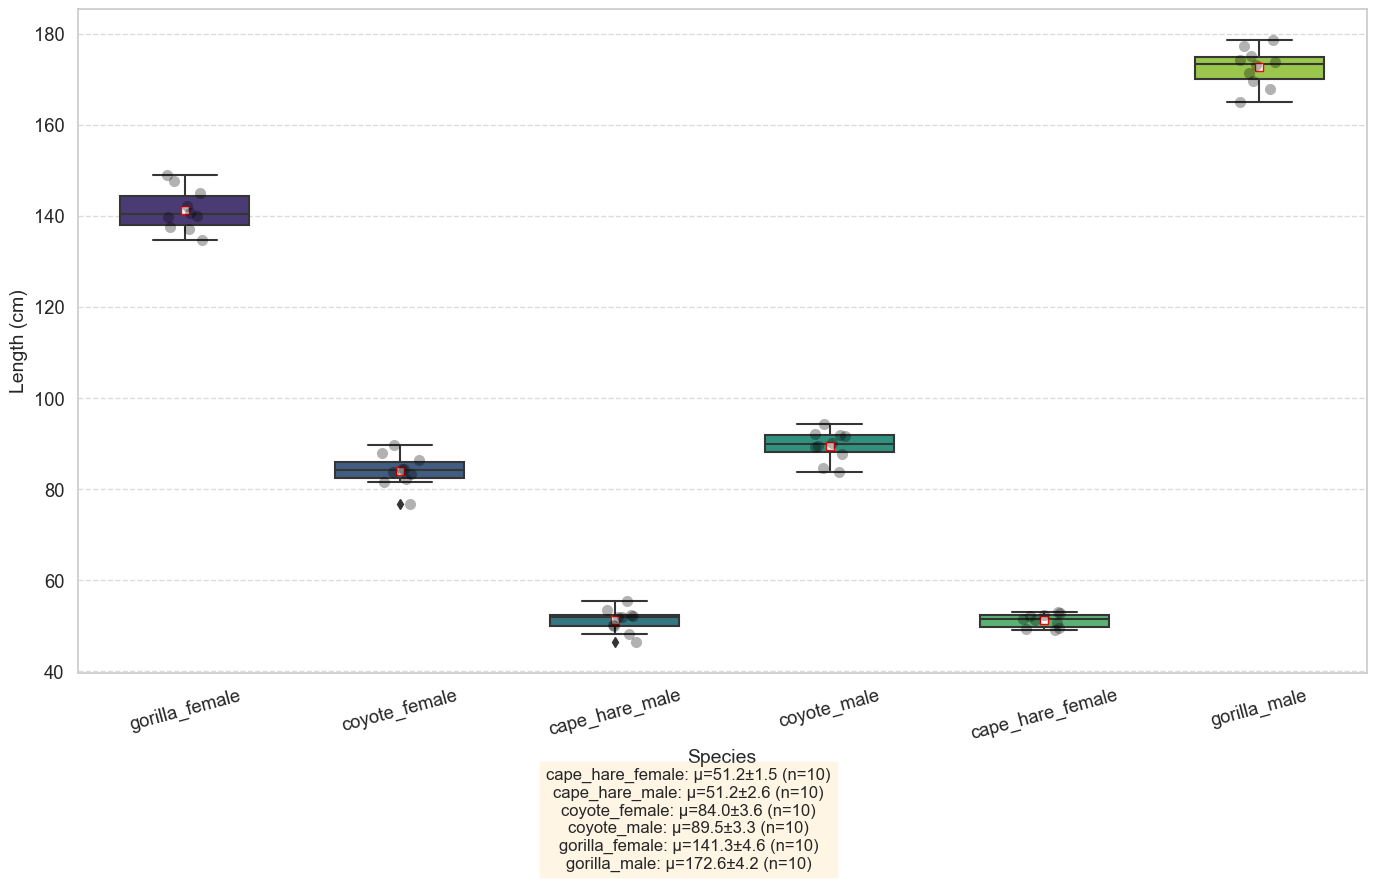

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='Species', 
    y='Length', 
    data=df,
    palette="viridis",
    width=0.6,
    showmeans=True,
    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"red"}
)

sns.stripplot(
    x='Species', 
    y='Length', 
    data=df,
    color='black',
    alpha=0.3,
    size=8,
    jitter=True
)

plt.xlabel('Species', fontsize=14)
plt.ylabel('Length (cm)', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

legend_text = []
for _, row in stats.iterrows():
    legend_text.append(f"{row['Species']}: μ={row['Mean']:.1f}±{row['Std']:.1f} (n={row['Count']})")

plt.figtext(0.5, -0.1, "\n".join(legend_text), 
            ha="center", fontsize=12, 
            bbox={"facecolor":"orange", "alpha":0.1, "pad":5})

plt.tight_layout()
plt.savefig('species_length_boxplot.png', dpi=600, bbox_inches='tight')
plt.show()

### Bayesian Species Classification Framework

This core function implements a Bayesian-Gaussian classification model that predicts species identity based on length measurements, providing both a classification result and probabilistic confidence.

The algorithm follows a statistically rigorous approach: first estimating Gaussian parameters ($\mu$ and $\sigma$) for each species from training data, then computing the likelihood of the unknown sample under each species' distribution using the normal probability density function. By applying Bayes' theorem with uniform priors, it converts these likelihoods into proper posterior probabilities that sum to 1. The function handles edge cases (like single-sample species) and returns both the most probable species and the complete probability distribution, enabling informed decision-making based on classification confidence. This Bayesian framework is particularly valuable in biological contexts where uncertainty quantification is essential for reliable interpretation.

In [12]:
from statistics import mean, stdev
import numpy as np

def predict_species(unknown_length, species_data, prob=True):
    species_params = {}
    for species, lengths in species_data.items():
        mu = mean(lengths)
        sigma = stdev(lengths) if len(lengths) > 1 else 0.1
        species_params[species] = (mu, sigma)
    
    likelihoods = {}
    for species, (mu, sigma) in species_params.items():
        exponent = -((unknown_length - mu) ** 2) / (2 * sigma ** 2)
        likelihood = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(exponent)
        likelihoods[species] = likelihood
    
    total = sum(likelihoods.values())
    probabilities = {s: l/total for s, l in likelihoods.items()}
    
    most_likely = max(probabilities, key=probabilities.get)
    
    if prob:
        print(f"\nUnknown Sample (Length = {unknown_length} cm)")
        print("\nSpecies Probability Distribution:")
        for species, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"- {species}: {prob:.4f} ({prob*100:.2f}%)")
        print(f"\nMost Likely Species: {most_likely} ({probabilities[most_likely]*100:.2f}%)")

    return most_likely, probabilities

### Example

Here is an example of the prediction of a unknown species that has the size of 50 cm.

The analysis shows that the 50 cm specimen is most likely a female Cape hare with a probability of 59.07%, while a male Cape hare (cape_hare_male) is the second most probable classification at 40.93%. All other species—including coyotes and gorillas of both sexes, are effectively ruled out with near-zero probabilities. This result reflects the biological reality that 50 cm falls within the overlapping size range of male and female Cape hares, but is much smaller than typical coyote or gorilla dimensions. The relatively modest confidence highlights the expected ambiguity when distinguishing between sexes of the same species, where size differences exist but with considerable overlap. The visualization clearly shows this competitive relationship between the two Cape hare categories, with no other species registering meaningful probability. This example demonstrates how the Bayesian framework provides nuanced insights, rather than forcing a definitive answer, it quantifies uncertainty and reveals the most biologically plausible interpretations based on the training data.


Unknown Sample (Length = 50 cm)

Species Probability Distribution:
- cape_hare_female: 0.5907 (59.07%)
- cape_hare_male: 0.4093 (40.93%)
- coyote_female: 0.0000 (0.00%)
- coyote_male: 0.0000 (0.00%)
- gorilla_female: 0.0000 (0.00%)
- gorilla_male: 0.0000 (0.00%)

Most Likely Species: cape_hare_female (59.07%)


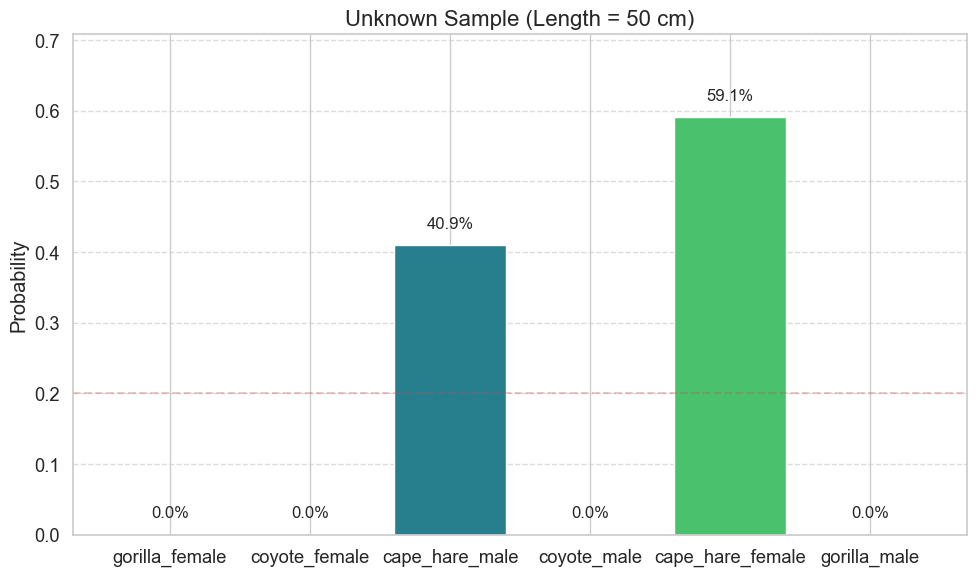

In [13]:
unknown_sample = 50
predicted_species, probabilities = predict_species(unknown_sample, species_length)

plt.figure(figsize=(10, 6))
species_list = list(probabilities.keys())
probs = [probabilities[s] for s in species_list]

plt.bar(species_list, probs, color=sns.color_palette("viridis", len(species_list)))
plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.3)
plt.title(f'Unknown Sample (Length = {unknown_sample} cm)', fontsize=16)
plt.ylabel('Probability')
plt.ylim(0, max(probs)*1.2)

for i, prob in enumerate(probs):
    plt.text(i, prob + 0.02, f'{prob:.1%}', 
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('classification_result.png', dpi=600, bbox_inches='tight')
plt.show()

## Broader Applications

The Bayesian-Gaussian framework demonstrates remarkable versatility across bioinformatics, extending far beyond species classification to address fundamental challenges in genomic analysis.

In RNA-seq studies, researchers apply this approach to identify differentially expressed genes by modeling read counts with Gaussian distributions and computing posterior probabilities of expression changes, providing not just significance values but quantifiable confidence in biological interpretations. The 1000 Genomes Project successfully employed similar Bayesian-Gaussian methods for genotype calling, where the framework's ability to handle uncertainty proved crucial for accurately identifying rare variants from noisy sequencing data.

In protein structure prediction, tools like AlphaFold incorporate Gaussian mixture models within their Bayesian scoring systems to evaluate conformational probabilities, demonstrating how these foundational statistical concepts scale to complex biological problems. Microbial ecologists routinely use this framework for source tracking through Shannon diversity indices, while epigeneticists apply it to analyze methylation patterns across genomic regions.

The enduring power of this approach lies in its elegant balance between statistical rigor and biological interpretability, particularly valuable when working with the small sample sizes common in biological experiments, where it transforms ambiguous measurements into probabilistic insights that directly inform experimental design and biological discovery.

## Further Reading

Here are some useful resources that can help you get started:

* Bayes' Theorem and Bioinformatics: (https://journals.aai.org/bib/article/8/2/109/221633)

* Probability Theory and Bioinformatics: (https://link.springer.com/chapter/10.1007/0-387-26648-8_1)